# Modelos Ensembles para Classificação de Imagens
(Notebook construído por Adrielson F. Justino)

### Ensemble baseado em Stacking

- O stacking,  são utilizados  dois  ou  mais  modelos  de  base,  geralmente  chamadosde modelos de nível 0, que se ajustam aos dados de treinamento e cujas previsões são compiladas; 

- Um metamodelo que combina as previsões dos modelos de base, chamadosde modelo de nível 1;

- Este notebook contém o treinamento de um modelo ensemble baseado em Staking, tendo como base três modelos de redes neurais convolucionais (**DenseNet121, VGG19 e ResNet50**) para classificação de imagens do conjunto de dados **CIFAR-10**.

### Baseado nos estudos: 

1 - [Classificação Automática de Petições Iniciais Usando Classificadores Combinados](https://sol.sbc.org.br/index.php/bresci/article/view/20479)

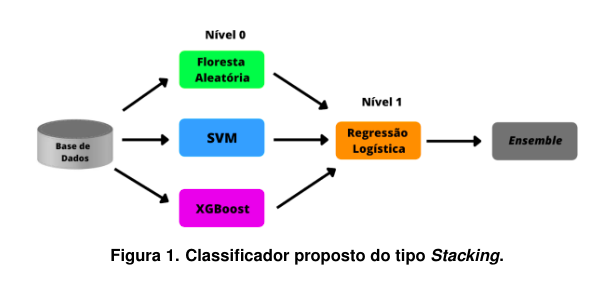

2 - [Implementação de Stacking Ensemble Learning para classificação de COVID-19 usando tomografia computadorizada de conjunto de dados de imagens e raio-X pulmonar](https://ieeexplore.ieee.org/document/9332112)

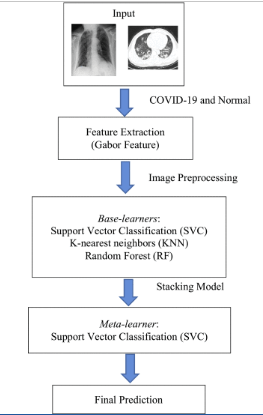

## Importação das dependências

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.applications import DenseNet121, VGG19, ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.datasets import cifar10

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 

## Carregando cojunto de dados CIFAR-10

Primeiramente vamos começar importando o conjunto de dados CIFAR-10, que é um conjunto de imagens rotuladas em 10 classes diferentes, contendo objetos comuns.

Também iremos definir a variável **percentage_to_keep**, que especifica a porcentagem do conjunto de dados original que desejamos manter. Neste exemplo, a porcentagem é definida como 0.5, o que significa que mantemos metade do conjunto de dados original.

In [3]:
(X_train_full, y_train_full), (X_test_full, y_test_full) = cifar10.load_data()

percentage_to_keep = 0.5 #35000

num_samples_to_keep = int(percentage_to_keep * len(X_train_full))

170498071/170498071 [==============================] - 7s 0us/step


Agora é feita a divisão do conjunto de treinamento **X_train** e os rótulos **y_train** para conter apenas o número de amostras calculado na etapa anterior.

In [4]:
X_train_full = X_train_full[:num_samples_to_keep]
y_train_full = y_train_full[:num_samples_to_keep]

X_train_full = (X_train_full - np.mean(X_train_full)) / np.std(X_train_full)
X_test_full = (X_test_full - np.mean(X_test_full)) / np.std(X_test_full)


X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

## Exibição das Informações do Conjunto de Dados

Iremos imprimir informações importantes sobre o conjunto de dados, incluindo o número classes no conjunto de dados, o tamanho do conjunto de treinamento (X_train e y_train), o tamanho do conjunto de teste (X_test e y_test) e 9 exemplos de imagens do conjunto de treinamento

In [5]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck',
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Train: X=(25000, 32, 32, 3), y=(25000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


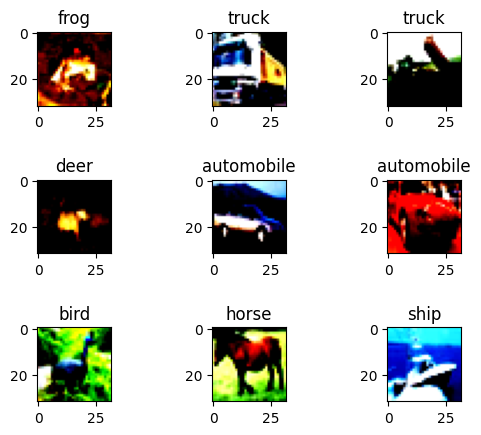

In [6]:
print('Train: X=%s, y=%s' % (X_train_full.shape, y_train_full.shape))
print('Test: X=%s, y=%s' % (X_test_full.shape, y_test_full.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(X_train_full[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train_full[i,0]])

plt.subplots_adjust(hspace = 1)
plt.show()

##  Diagrama do modelo proposto
- No diagrama estão dispostos os níveis do classificador e o metamodelo combinador.

- Os classificadores-base (nível 0) utilizados para construir o modelo ensemble foram três modelos de redes neurais convolucionais: DenseNet121, VGG19 e ResNet50. 

- No meta-classificador (Nível 1) foi usado o RandomForestClassifier. Para isso as previsões dos modelos base foram combinadas e usadas como features para treinar um meta-classificador.

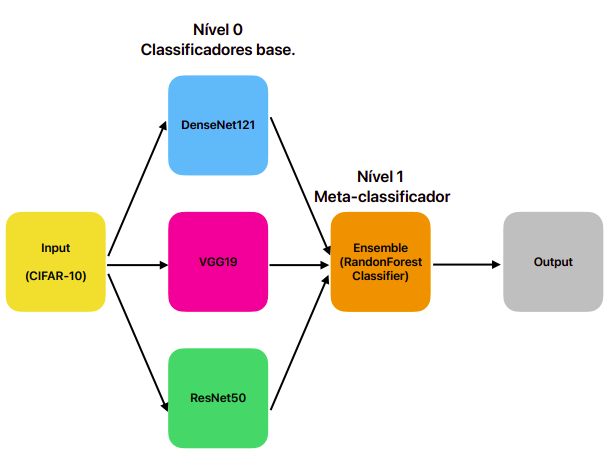


### Previsões do Ensemble: 
- Depois de treinado, o modelo meta-classificador foi usado para fazer previsões no conjunto de dados de teste. 

### Avaliação: 
- As previsões do modelo de ensemble foram avaliadas para calcular métricas de desempenho de acurácia, precisão, recall e F1-score.

## Definição dos modelos base (Nível 0)

- Redes neurais convolucionais pré-treinadas

### DenseNet121

In [7]:
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
x_densenet = base_model_densenet.output
x_densenet = Flatten()(x_densenet)
output_densenet = Dense(10, activation='softmax')(x_densenet)
model_densenet = Model(inputs=base_model_densenet.input, outputs=output_densenet)

29084464/29084464 [==============================] - 0s 0us/step


#### VGG19

In [8]:
base_model_vgg = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
x_vgg = base_model_vgg.output
x_vgg = Flatten()(x_vgg)
output_vgg = Dense(10, activation='softmax')(x_vgg)
model_vgg = Model(inputs=base_model_vgg.input, outputs=output_vgg)

80134624/80134624 [==============================] - 1s 0us/step


### ResNet-50

In [9]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for layer in base_model_resnet.layers:
    layer.trainable = False
x_resnet = base_model_resnet.output
x_resnet = Flatten()(x_resnet)
output_resnet = Dense(10, activation='softmax')(x_resnet)
model_resnet = Model(inputs=base_model_resnet.input, outputs=output_resnet)

94765736/94765736 [==============================] - 1s 0us/step


## Early Stopping

Interromper o treinamento se não houver melhoria após 3 épocas.

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Treinamento dos modelos base

- Early Stopping;
- 100 épocas;
- batch_size=64

In [11]:
model_densenet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_densenet.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
313/313 [==============================] - 105s 93ms/step - loss: 1.1235 - accuracy: 0.6150 - val_loss: 1.1666 - val_accuracy: 0.6508
Epoch 2/100
313/313 [==============================] - 23s 73ms/step - loss: 0.8445 - accuracy: 0.7182 - val_loss: 1.0959 - val_accuracy: 0.6986
Epoch 3/100
313/313 [==============================] - 23s 73ms/step - loss: 0.5972 - accuracy: 0.7930 - val_loss: 0.8331 - val_accuracy: 0.7268
Epoch 4/100
313/313 [==============================] - 23s 74ms/step - loss: 0.5908 - accuracy: 0.8039 - val_loss: 0.7821 - val_accuracy: 0.7568
Epoch 5/100
313/313 [==============================] - 23s 73ms/step - loss: 0.6814 - accuracy: 0.7777 - val_loss: 0.7211 - val_accuracy: 0.7444
Epoch 6/100
313/313 [==============================] - 23s 73ms/step - loss: 0.3982 - accuracy: 0.8623 - val_loss: 0.6533 - val_accuracy: 0.7852
Epoch 7/100
313/313 [==============================] - 23s 72ms/step - loss: 0.2789 - accuracy: 0.9046 - val_loss: 0.6737 - val_a

In [12]:
model_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_vgg.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
313/313 [==============================] - 24s 53ms/step - loss: 1.9662 - accuracy: 0.2122 - val_loss: 1.8677 - val_accuracy: 0.2372
Epoch 2/100
313/313 [==============================] - 14s 46ms/step - loss: 1.7695 - accuracy: 0.2889 - val_loss: 2.4436 - val_accuracy: 0.3080
Epoch 3/100
313/313 [==============================] - 14s 46ms/step - loss: 1.6119 - accuracy: 0.3562 - val_loss: 1.5253 - val_accuracy: 0.3758
Epoch 4/100
313/313 [==============================] - 14s 46ms/step - loss: 1.3981 - accuracy: 0.4638 - val_loss: 1.4282 - val_accuracy: 0.4520
Epoch 5/100
313/313 [==============================] - 14s 46ms/step - loss: 1.2581 - accuracy: 0.5217 - val_loss: 1.3110 - val_accuracy: 0.5078
Epoch 6/100
313/313 [==============================] - 14s 46ms/step - loss: 1.1263 - accuracy: 0.5854 - val_loss: 1.2036 - val_accuracy: 0.5660
Epoch 7/100
313/313 [==============================] - 14s 46ms/step - loss: 1.0200 - accuracy: 0.6269 - val_loss: 1.0927 - val_ac

In [13]:
model_resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_resnet.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
313/313 [==============================] - 10s 21ms/step - loss: 1.9560 - accuracy: 0.3001 - val_loss: 1.7859 - val_accuracy: 0.3640
Epoch 2/100
313/313 [==============================] - 5s 15ms/step - loss: 1.7328 - accuracy: 0.3882 - val_loss: 1.7355 - val_accuracy: 0.3934
Epoch 3/100
313/313 [==============================] - 5s 15ms/step - loss: 1.6606 - accuracy: 0.4130 - val_loss: 1.6945 - val_accuracy: 0.4012
Epoch 4/100
313/313 [==============================] - 5s 15ms/step - loss: 1.6157 - accuracy: 0.4319 - val_loss: 1.6436 - val_accuracy: 0.4184
Epoch 5/100
313/313 [==============================] - 4s 14ms/step - loss: 1.5877 - accuracy: 0.4456 - val_loss: 1.6655 - val_accuracy: 0.4086
Epoch 6/100
313/313 [==============================] - 5s 15ms/step - loss: 1.5695 - accuracy: 0.4511 - val_loss: 1.6026 - val_accuracy: 0.4390
Epoch 7/100
313/313 [==============================] - 5s 15ms/step - loss: 1.5441 - accuracy: 0.4589 - val_loss: 1.6191 - val_accuracy

In [14]:
#Previsões dos modelos - para teste
preds_densenet = model_densenet.predict(X_test_full)
preds_vgg = model_vgg.predict(X_test_full)
preds_resnet = model_resnet.predict(X_test_full)

313/313 [==============================] - 4s 9ms/step


In [15]:
# Métricas
metrics_individual = {}
metrics_individual['DenseNet121'] = {
    'Accuracy': accuracy_score(y_test_full, np.argmax(preds_densenet, axis=1)),
    'Precision': precision_score(y_test_full, np.argmax(preds_densenet, axis=1), average='weighted'),
    'Recall': recall_score(y_test_full, np.argmax(preds_densenet, axis=1), average='weighted'),
    'F1-Score': f1_score(y_test_full, np.argmax(preds_densenet, axis=1), average='weighted')
}
metrics_individual['VGG19'] = {
    'Accuracy': accuracy_score(y_test_full, np.argmax(preds_vgg, axis=1)),
    'Precision': precision_score(y_test_full, np.argmax(preds_vgg, axis=1), average='weighted'),
    'Recall': recall_score(y_test_full, np.argmax(preds_vgg, axis=1), average='weighted'),
    'F1-Score': f1_score(y_test_full, np.argmax(preds_vgg, axis=1), average='weighted')
}
metrics_individual['ResNet50'] = {
    'Accuracy': accuracy_score(y_test_full, np.argmax(preds_resnet, axis=1)),
    'Precision': precision_score(y_test_full, np.argmax(preds_resnet, axis=1), average='weighted'),
    'Recall': recall_score(y_test_full, np.argmax(preds_resnet, axis=1), average='weighted'),
    'F1-Score': f1_score(y_test_full, np.argmax(preds_resnet, axis=1), average='weighted')
}

## Treinamento do ensemble stacking (usando RandomForest como meta-classificador)

In [16]:
ensemble_X_train = np.concatenate([preds_densenet, preds_vgg, preds_resnet], axis=1)


In [17]:
stacking_model = RandomForestClassifier(n_estimators=50, random_state=42)
stacking_model.fit(ensemble_X_train, y_test_full)

/tmp/ipykernel_42/331538618.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  stacking_model.fit(ensemble_X_train, y_test_full)


RandomForestClassifier(n_estimators=50, random_state=42)

### Preparação dos dados de teste para o ensemble e Previsões usando o modelo

In [18]:
X_test_ensemble = np.concatenate([preds_densenet, preds_vgg, preds_resnet], axis=1)

In [19]:
ensemble_predictions = stacking_model.predict(X_test_ensemble)

In [20]:
# Métricas do ensemble
metrics_individual['Ensemble'] = {
    'Accuracy': accuracy_score(y_test_full, ensemble_predictions),
    'Precision': precision_score(y_test_full, ensemble_predictions, average='weighted'),
    'Recall': recall_score(y_test_full, ensemble_predictions, average='weighted'),
    'F1-Score': f1_score(y_test_full, ensemble_predictions, average='weighted')
}



### Avaliação

In [21]:
metrics_df = pd.DataFrame(metrics_individual).T
print(metrics_df)

             Accuracy  Precision  Recall  F1-Score
DenseNet121    0.7811   0.788291  0.7811  0.780433
VGG19          0.7093   0.713869  0.7093  0.710234
ResNet50       0.4507   0.456446  0.4507  0.450263
Ensemble       0.9998   0.999800  0.9998  0.999800


### Modelos individuais:
* O modelo **DenseNet121** teve o melhor desempenho, alcançando uma acurácia de **78.11%**. 
* Esse **padrão se repetiu** nas métricas de precisão, recall e F1-Score, onde DenseNet121 superou os outros modelos.

### Modelo Ensemble
* A combinação desses modelos no ensemble resultou em um desempenho superior em todas as métricas avaliadas.
* O ensemble alcançou uma acurácia de **99.98%**
* Precisão, recall e F1-Score também em **99.98%**.

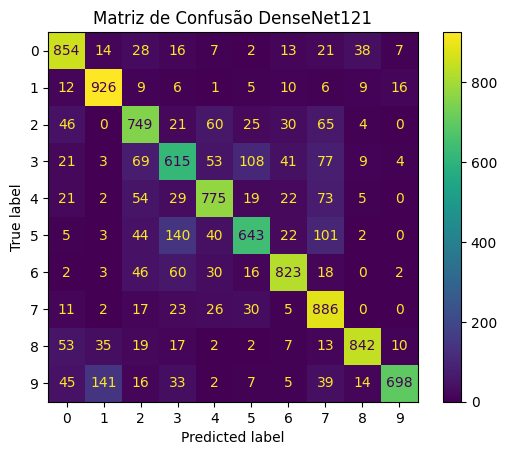

In [29]:
cm_densenet = confusion_matrix(y_true=y_test_full, y_pred=np.argmax(preds_densenet, axis=1))

cm_display_densenet = ConfusionMatrixDisplay(confusion_matrix=cm_densenet, display_labels=np.unique(y_test_full))
cm_display_densenet.plot()
plt.title('Matriz de Confusão DenseNet121')
plt.show()

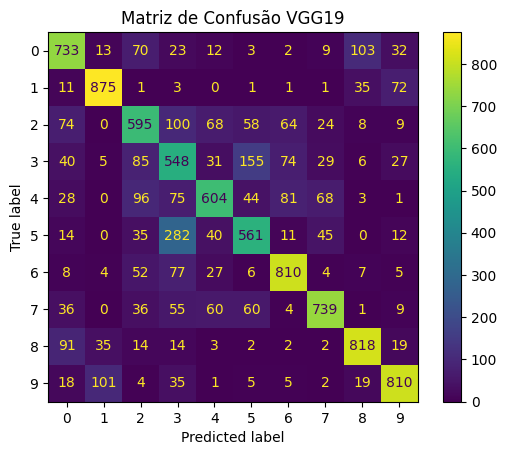

In [30]:
cm_vgg = confusion_matrix(y_true=y_test_full, y_pred=np.argmax(preds_vgg, axis=1))

cm_display_vgg = ConfusionMatrixDisplay(confusion_matrix=cm_vgg, display_labels=np.unique(y_test_full))
cm_display_vgg.plot()
plt.title('Matriz de Confusão VGG19')
plt.show()

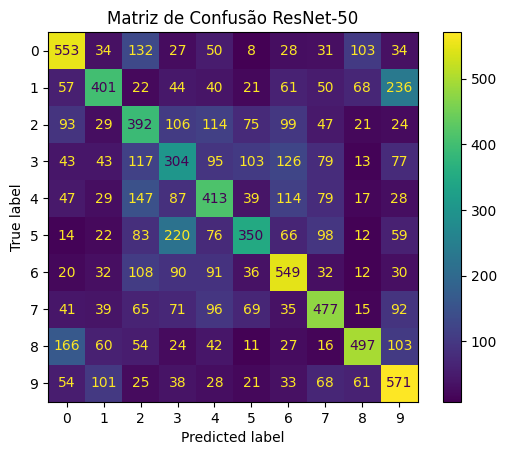

In [32]:
cm_resnet = confusion_matrix(y_true=y_test_full, y_pred=np.argmax(preds_resnet, axis=1))

cm_display_resnet = ConfusionMatrixDisplay(confusion_matrix=cm_resnet, display_labels=np.unique(y_test_full))
cm_display_resnet.plot()
plt.title('Matriz de Confusão ResNet-50')
plt.show()

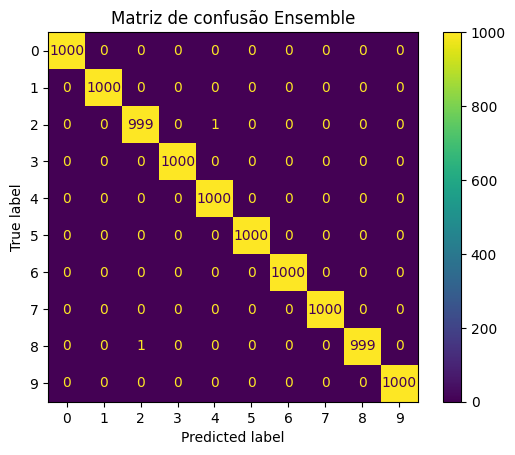

In [33]:
cm_ensemble = confusion_matrix(y_true=y_test_full, y_pred=ensemble_predictions)

cm_display_ensemble = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble, display_labels=np.unique(y_test_full))
cm_display_ensemble.plot()
plt.title('Matriz de confusão Ensemble')
plt.show()

In [22]:
print("Reporte:")
print(classification_report(y_true=y_test_full, y_pred=ensemble_predictions))

Reporte:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00      1000
           2       1.00      1.00      1.00      1000
           3       1.00      1.00      1.00      1000
           4       1.00      1.00      1.00      1000
           5       1.00      1.00      1.00      1000
           6       1.00      1.00      1.00      1000
           7       1.00      1.00      1.00      1000
           8       1.00      1.00      1.00      1000
           9       1.00      1.00      1.00      1000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



**Isso é tudo pessoal!!!**

adrielferreira28@gmail.com